In [8]:
import h5py
import os

import fenics as fe
import numpy as np
import matplotlib.pyplot as plt
import xarray as xr

from tqdm import tqdm

fe.set_log_level(50)

In [9]:
ds = xr.open_dataset("../data/Run08_G0_dt4.0_de1.0_ne5_velocity.nc")

u_spatial_averaged = np.mean(ds.U, axis=(1, 2, 3))
v_spatial_averaged = np.mean(ds.V, axis=(1, 2, 3))

idx_start = np.argmin(np.abs(u_spatial_averaged.values - 0.))
idx_end = len(u_spatial_averaged.values)

ds

<xarray.Dataset>
Dimensions:  (time: 236, x: 64, y: 48, z: 32)
Coordinates:
  * time     (time) datetime64[ns] 2016-07-14T23:41:56.464000 ... 2016-07-14T...
  * x        (x) float32 0.01056 0.01584 0.02112 0.0264 ... 0.3326 0.3379 0.3432
  * y        (y) float32 0.01056 0.01584 0.02112 0.0264 ... 0.2482 0.2534 0.2587
  * z        (z) float32 0.003 0.0045 0.006 0.0075 ... 0.045 0.0465 0.048 0.0495
Data variables:
    U        (time, x, y, z) float64 0.001353 0.002407 ... 0.005629 0.005749
    V        (time, x, y, z) float64 0.0005055 0.0008135 ... 0.0004942 0.0005105
    W        (time, x, y, z) float64 ...
Attributes: (12/38)
    Beta:                    83.33333333333336
    D:                       0.1
    Delta+:                  0.2066877575491193
    Delta_l:                 0.03883251825111399
    Delta_s:                 0.006180387232371034
    KC:                      4.965312104433688
    ...                      ...
    run_id:                  Run08
    source:                  3DPIV applied to Synthetic Aperture Imagery
    title:                   Three dimensional particle imaging velocimetry data
    velocityError:           0.4601796502946466
    vorticityError:          0.07719118675993733
    license:                 https://creativecommons.org/licenses/by/4.0/lega...

In [10]:
u_depth_averaged = np.mean(ds.U, axis=-1)
v_depth_averaged = np.mean(ds.V, axis=-1)

u_depth_averaged = u_depth_averaged.isel(time=slice(idx_start, idx_end))
v_depth_averaged = v_depth_averaged.isel(time=slice(idx_start, idx_end))

u_spatial_averaged = u_spatial_averaged.isel(time=slice(idx_start, idx_end))
v_spatial_averaged = v_spatial_averaged.isel(time=slice(idx_start, idx_end))

u_depth_averaged = u_depth_averaged.assign_coords(
    dict(time_rel=((u_depth_averaged["time"]  - u_depth_averaged["time"][0]) * 1e-9).astype(float)))
v_depth_averaged = v_depth_averaged.assign_coords(
    dict(time_rel=((v_depth_averaged["time"]  - v_depth_averaged["time"][0]) * 1e-9).astype(float)))

In [29]:
dx = ds.attrs["dx"]
dy = ds.attrs["dy"]
U = u_depth_averaged[50, :, :].to_numpy()
V = v_depth_averaged[50, :, :].to_numpy()
print(U.shape, V.shape)

divergence_est = np.gradient(U, dx, axis=0, edge_order=2) + np.gradient(V, dy, axis=1, edge_order=2)
print(divergence_est.shape)
print(np.std(divergence_est[np.logical_not(np.isnan(divergence_est))]))

(64, 48) (64, 48)
(64, 48)
0.017474570708516296


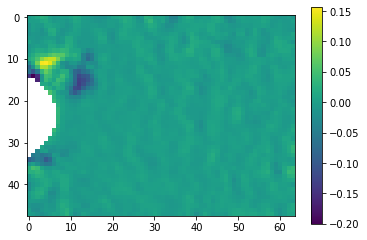

In [12]:
im = plt.imshow(divergence_est.T)
plt.colorbar(im)
plt.show()

2.306277067646495e-14


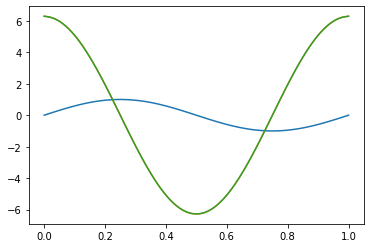

In [13]:
# doing some testing
x = np.linspace(0, 1, 100)
dx = x[1] - x[0]

f = np.sin(2 * np.pi * x)
id = np.eye(len(f))

D = np.gradient(id, dx, axis=0, edge_order=2)
print(np.linalg.norm(np.gradient(f, dx, edge_order=2) - D @ f))

plt.plot(x, f)
plt.plot(x, D @ f)
plt.plot(x, np.gradient(f, dx, edge_order=2))
plt.show()

In [24]:
# redefine
from jax import numpy as jnp

dx = ds.attrs["dx"]
dy = ds.attrs["dy"]

def divergence(u, v):
    return (jnp.gradient(u, dx, axis=0) 
            + jnp.gradient(v, dy, axis=1))

In [17]:
Uj, Vj = jnp.array(U), jnp.array(V)

divergence(Uj, Vj)

Array([[-0.00349017,  0.00031383, -0.00705021, ..., -0.01694111,
        -0.0099858 , -0.00691267],
       [ 0.00205132,  0.00053796,  0.00035444, ..., -0.01734808,
        -0.02054763, -0.00820733],
       [ 0.0101046 ,  0.00148907, -0.00418258, ..., -0.01791625,
        -0.02384225, -0.01511198],
       ...,
       [-0.00666124, -0.00755682, -0.00570665, ..., -0.00509062,
        -0.00430911, -0.00412847],
       [-0.00341122, -0.00890268, -0.00889442, ...,  0.00625963,
         0.00878938,  0.00849792],
       [-0.00824802, -0.00403204, -0.00640665, ...,  0.00903736,
         0.01027185,  0.00821003]], dtype=float32)

In [39]:
from jax import jacfwd
J = jacfwd(divergence, 0)(Uj, Vj)
J_zeros = jacfwd(divergence, 0)(jnp.zeros_like(Uj), jnp.zeros_like(Vj))

# verify that there is no dependence on the input space
assert jnp.linalg.norm(J - J_zeros) <= 1e-12

In [43]:
jnp.tensordot(J, Uj)

Array([[nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       ...,
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan]], dtype=float32)